
# <p style="text-align: center;">MIS 382N: ADVANCED PREDICTIVE MODELING - MSBA</p>
# <p style="text-align: center;">Assignment 5 - BONUS - SECTION-B (5.30pm to 7pm class)</p>
## <p style="text-align: center;">Points: 95, Bonus: 40 </p>
## <p style="text-align: center;">Due: November 30, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Your partner needs to be from the same section. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTEID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group. If you do change, let the TA know. 

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

### Name(s)
1. Kaiwen Zhang (kz4493)
2. Matthew Ruffner (mar9632)

# Question 1 : Bayesian Belief Networks (15 pts)

![Question 1](https://i.imgur.com/3ayVbFi.jpeg) 

All nodes are binary and can take 0/1 values

The probabilities are given below:

P(Bark = 1) = 0.05   
P(Rain = 1) = 0.01


P(Scared = 1 | Bark = 0, Rain = 0) = 0.001  
P(Scared = 1 | Bark = 0, Rain = 1) = 0.1  
P(Scared = 1 | Bark = 1, Rain = 0) = 0.8  
P(Scared = 1 | Bark = 1, Rain = 1) = 0.9  

P(Hides = 1 | Scared = 1) = 0.95  
P(Hides = 1 | Scared = 0) = 0.05  

For the given Bayesian network, Compute the following probabilities :  


**(a) (4 pts)** Find the probability that cat hides = 1.  
**(b) (4 pts)** Given that cat got scared (Scared = 1), what is the probability that it rained (Rain = 1)?  
**(c) (7 pts)** Given that cat got scared (Scared = 1) and the dog barked (Bark = 1), what is the probability that it rained (Rain = 1)?

## a

P(Bark = 0) = 0.95, P(Rain = 0) = 0.99, P(Bark = 0 & Rain = 0) = 0.95\*0.99 = 0.9405

P(Bark = 0 & Rain = 1) = 0.0095

P(Bark = 1 & Rain = 0) = 0.0495

P(Bark = 1 & Rain = 1) = 0.0005

P(Scared = 1 & Bark = 0 & Rain = 0) = 0.9405\*0.001 = 0.0009405

P(Scared = 1 & Bark = 0 & Rain = 1) = 0.00095

P(Scared = 1 & Bark = 1 & Rain = 0) = 0.0396

P(Scared = 1 & Bark = 1 & Rain = 1) = 0.00045

P(Scared = 1) = 0.0009405+0.00095+0.0396+0.00045 = 0.0419405

P(Scared = 0) = 0.9580595

P(Hides = 1 & Scared = 1) = 0.95\*0.0419405 = 0.95\*0.0419405 = 0.039843475

P(Hides = 1 & Scared = 0) = 0.047902975

**P(Hides = 1) = 0.08774645**

## b

P(Rain = 1 | Scared = 1) = P(Scared = 1 & Rain = 1) / P(Scared = 1) = (P(Scared = 1 & Bark = 0 & Rain = 1) + P(Scared = 1 & Bark = 1 & Rain = 1)) / P(Scared = 1) = (0.00095 + 0.00045) / 0.0419405 = **0.03338062254**

## c

P(Rain = 1 | Scared = 1 & Bark = 1) = P(Rain = 1 & Scared = 1 & Bark = 1) / P(Scared = 1 & Bark = 1) = P(Rain = 1 & Scared = 1 & Bark = 1) / (P(Scared = 1 & Bark = 1 & Rain = 0)+P(Scared = 1 & Bark = 1 & Rain = 1)) = 0.00045 / (0.0396+0.00045) = **0.01123595505**

# Question 2 - **Random Forest (30 pts)**  

The goal of this problem is to explore the effect of feature selection using  the following dataset (same as in HW 4) https://www.kaggle.com/wendykan/lending-club-loan-data

Since the dataset is really huge, we will use only a certain set of features and samples to build our model. We will also use only two classes instead of all.

The modified dataset with reduced number of samples has been prepared for your use. The file can be downloaded using the code below. You can also find it [here](https://drive.google.com/file/d/1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs/view?usp=sharing) in case you have a different environment and this code does not run.



In [1]:
%%bash
ggID='1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  

if [ -e "${filename}" ]; then
    echo 'File already exists'
else
    curl -Lb /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  
fi

File already exists


In [2]:
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)
df.head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,...,last_pymnt_d_Feb-2019,last_pymnt_d_Jan-2019,last_pymnt_d_Jul-2018,last_pymnt_d_Nov-2018,last_pymnt_d_Oct-2018,last_pymnt_d_Sep-2018,application_type_Individual,application_type_Joint App,debt_settlement_flag_N,debt_settlement_flag_Y
0,2500,2500,2500.0,13.56,84.92,55000.0,1,18.24,9.0,1.0,...,1,0,0,0,0,0,1,0,1,0
1,30000,30000,30000.0,18.94,777.23,90000.0,1,26.52,13.0,1.0,...,1,0,0,0,0,0,1,0,1,0
2,5000,5000,5000.0,17.97,180.69,59280.0,1,10.51,8.0,0.0,...,1,0,0,0,0,0,1,0,1,0
3,4000,4000,4000.0,18.94,146.51,92000.0,1,16.74,10.0,0.0,...,1,0,0,0,0,0,1,0,1,0
4,30000,30000,30000.0,16.14,731.78,57250.0,1,26.35,12.0,0.0,...,1,0,0,0,0,0,1,0,1,0


Select the `loan_status` column as the target column.  


**Part 1: (3 pts)** Split the dataset into train and test set with 25% data in test set and random_state = 42. Perform [Min-Max Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on the dataset. Print the total number of features. 

**Part 2: (5 pts)** Use the dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  

**Part 3: (6 pts)** Use [$\chi^2$ test](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  

**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   

**Part 4: (6 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  

**Part 5: (8 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))  

**Part 6: (2 pts)** What do you observe from the ROC curves?

# Solution

In [3]:
df = df.fillna(0)
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']

a.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled_train = min_max_scaler.fit_transform(X_train)
X_scaled_test = min_max_scaler.fit_transform(X_test)

# X_scaled = pd.DataFrame(X_scaled)

In [6]:
print('Total number of features:', len(df.columns)-1)

Total number of features: 160


b.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=5, random_state=42)
clf.fit(X_scaled_train, y_train)
print(classification_report(y_test, clf.predict(X_scaled_test)))

              precision    recall  f1-score   support

           0       0.64      0.38      0.47       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.81      0.69      0.73     56517
weighted avg       0.99      0.99      0.99     56517



c.

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

KBest_model_100 = SelectKBest(chi2, k=100)
KBest_model_30 = SelectKBest(chi2, k=30)
KBest_model_10 = SelectKBest(chi2, k=10)

X_new_sc_train_100 = KBest_model_100.fit_transform(X_scaled_train, y_train)
X_new_sc_train_30 = KBest_model_30.fit_transform(X_scaled_train, y_train)
X_new_sc_train_10 = KBest_model_10.fit_transform(X_scaled_train, y_train)

X_new_sc_test_100 = KBest_model_100.transform(X_scaled_test)
X_new_sc_test_30 = KBest_model_30.transform(X_scaled_test)
X_new_sc_test_10 = KBest_model_10.transform(X_scaled_test)

clf_100 = RandomForestClassifier(n_estimators=5, random_state=42)
clf_100.fit(X_new_sc_train_100, y_train)
print('100 features:')
print(classification_report(y_test, clf_100.predict(X_new_sc_test_100)))

clf_30 = RandomForestClassifier(n_estimators=5, random_state=42)
clf_30.fit(X_new_sc_train_30, y_train)
print('30 features:')
print(classification_report(y_test, clf_30.predict(X_new_sc_test_30)))

clf_10 = RandomForestClassifier(n_estimators=5, random_state=42)
clf_10.fit(X_new_sc_train_10, y_train)
print('10 features:')
print(classification_report(y_test, clf_10.predict(X_new_sc_test_10)))


100 features:
              precision    recall  f1-score   support

           0       0.66      0.44      0.53       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.82      0.72      0.76     56517
weighted avg       0.99      0.99      0.99     56517

30 features:
              precision    recall  f1-score   support

           0       0.49      0.13      0.21       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.98     56517
   macro avg       0.74      0.56      0.60     56517
weighted avg       0.98      0.98      0.98     56517

10 features:
              precision    recall  f1-score   support

           0       1.00      0.07      0.14       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.99      0.54      0.56     56517
weighted avg       0.99      0.99 

d.

<Figure size 432x288 with 0 Axes>

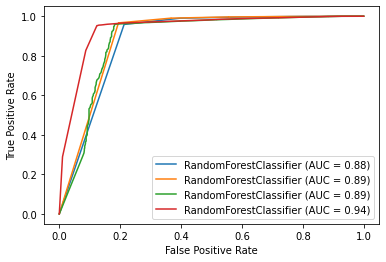

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

plt.figure()
disp = plot_roc_curve(clf, X_scaled_test, y_test)
plot_roc_curve(clf_100, X_new_sc_test_100, y_test, ax=disp.ax_);
plot_roc_curve(clf_30, X_new_sc_test_30, y_test, ax=disp.ax_);
plot_roc_curve(clf_10, X_new_sc_test_10, y_test, ax=disp.ax_);
plt.show()

e.

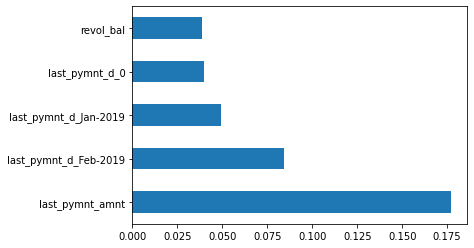

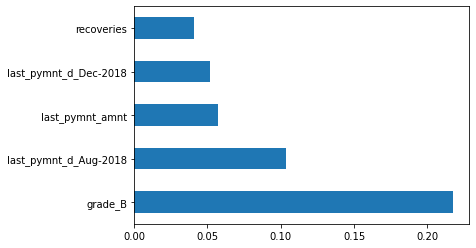

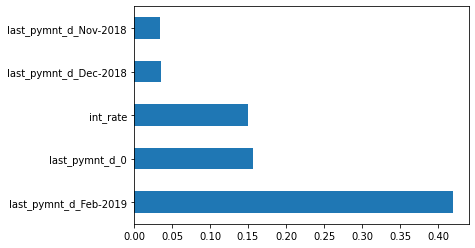

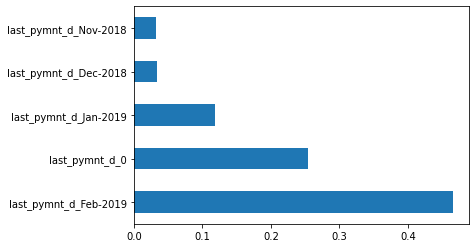

In [10]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

# Create and fit selector
selector = SelectKBest(chi2, k=100).fit(X_scaled_test, y_test)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
feat_importances = pd.Series(clf_100.feature_importances_, index=features_df_new.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

# Create and fit selector
selector = SelectKBest(chi2, k=30).fit(X_scaled_test, y_test)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
feat_importances = pd.Series(clf_30.feature_importances_, index=features_df_new.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

# Create and fit selector
selector = SelectKBest(chi2, k=10).fit(X_scaled_test, y_test)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
feat_importances = pd.Series(clf_10.feature_importances_, index=features_df_new.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

f.

Three models have similar AUC values in the 90's percentages, while the fourth has noticeably lower AUC value. In other words, as an aggregate measure of model performance, there is a roughly 90% chance that a randomly chosen loan_status=1 class will have a higher rank. (In the case of a non-closed-form model such as random forest, "rank" can be analogously considered as the proportion of out-of-bag votes for loan_status=1.) The pure random forest model had the lowest AUC value probably because the K-Best selector weeds out irrelevant features, and therefore reduces overfitting caused by the consideration of these irrelevant features.

# Question 3 : Logistic Regression with Regularization and Decision Tree (25 pts)

The goal of this problem is to explore the effect of regularization on logistic regression for binary classification, we will be using the diabetes dataset. 
This dataset is used to predict if a person is having 
diabetes based on feature variables including blood pressure, bmi, age etc. The target variable is stored in "outcome" column.

* Load the "diabetes.csv" and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 


* We need to use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on the original data, we use StandardScaler to center each feature. Also remember that when we have training and testing data, we fit preprocessing parameters on training data and apply them to all testing data. You should scale only the features (independent variables), not the target variable y. 

   Note: X should have 8 features.


**Part 1: (6 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty $l2$
(Ridge Regularization) for the following values of regularization  C = $[0.0001,0.001,0.1,10,100]$ using the training data. Report the accuracy score on the test data averaged over 5 runs of the model for each of the C values. 

  Note : Smaller values of C indicate stronger regularization

    

**Part 2: (6 pts)** Fit a [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifier on the training data, and report the accuracy score on the test data averaged over 5 runs. Briefly explain which of the models performed the best Logistic Regression + regularization or Decision Tree Classifier and why. 


* Now, We will check if the decision boundary from logistic regression is linear by using a 2D plot.


**Part 3: (4 pts)** Select the top two most important features ([Feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)) using the training data with a Decision Tree Classifier and random_state = 10. Subset the train and test data to have only the selected features. This will be used as the training and test data for part $4$.


**Part 4: (8 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty = $l2$, C = 10 (Ridge Regularization) and random state = 0 for the training data from part $3$ . Plot the decision boundary of the logistic regression model with the two features, as X and Y axis. Here is an [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html) . Plot the scatter points for the test data, on the same graph showing the two classes as two different color. 

  * Hint : You can use the below limits for plotting the decision boundary, where $X[:,0]$ indicates feature 1 values and $X[:,1]$ indicates feature 2 values of the train dataset. 

     $ x_\min, x_\max = X[:, 0].min() - .5, X[:, 0].max() + .5 $ 

     $ y_\min, y_\max = X[:, 1].min() - .5, X[:, 1].max() + .5 $
   

# Solution

#### Loading dataset and pre-processing (**1 pt**)

In [11]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('diabetes.csv')
df = df.fillna(0)

X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

std_scaler = StandardScaler()

X_scaled_train = std_scaler.fit_transform(X_train)
X_scaled_test = std_scaler.fit_transform(X_test)

FileNotFoundError: [Errno 2] File diabetes.csv does not exist: 'diabetes.csv'

#### Part 1 (**6 pts**)

### Part 1 logistic regression issues

In [ ]:
from sklearn.linear_model import LogisticRegression

C_list = [0.0001,0.001,0.1,10,100] 


for element in C_list:
    counter = 0
    value = 0
    for i in range(5):
        clf = LogisticRegression(C=element).fit(X_scaled_train, y_train)
        print(f'For C={element} and run {i+1}:', clf.score(X_scaled_test, y_test))
        counter += 1
        value += clf.score(X_scaled_test, y_test)
    print('Average score:', value / counter)

#### Part 2 (**6 pts**)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

counter = 0
value = 0
for i in range(5):
    clf = DecisionTreeClassifier().fit(X_scaled_train, y_train)
    counter += 1
    print(counter, clf.score(X_scaled_test, y_test))
    value += clf.score(X_scaled_test, y_test)

print('Average score:', value / counter)

Logistic regression with C=10 had the best score even though the scores for decision tree were more consistent. This may be because we can account for overfitting with logistic regression but this is not possible with decision tree -- decision tree may be better than the un-regularized logistic regression model but it cannot significantly improve.

#### Part 3 (**4 pts**)

In [ ]:
importance_values = pd.Series(DecisionTreeClassifier(random_state=10).fit(X_scaled_train, y_train).feature_importances_)

importance_names = pd.Series(df.columns)

importance_df = pd.concat([importance_names, importance_values], axis=1)

importance_df = importance_df.iloc[:8,:]

importance_df.sort_values(by=[1],ascending=False)[0][:2]

In [ ]:
two_features = ['Glucose', 'BMI']

X_sc_red_train = pd.DataFrame(X_scaled_train)[[1,5]]
X_sc_red_test = pd.DataFrame(X_scaled_test)[[1,5]]

#### Part 4 (**8 pts**)

In [ ]:
clf = LogisticRegression(random_state=0, C=10)
clf.fit(X_sc_red_train, y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_sc_red_train.loc[:, 1].min() - .5, X_sc_red_train.loc[:, 1].max() + .5
y_min, y_max = X_sc_red_train.loc[:, 5].min() - .5, X_sc_red_train.loc[:, 5].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
train_scatter = plt.scatter(X_sc_red_train.loc[:, 1], X_sc_red_train.loc[:, 5], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
# plt.legend('Train')
test_scatter = plt.scatter(X_sc_red_test.loc[:, 1], X_sc_red_test.loc[:, 5], c=y_test, edgecolors='m', cmap=plt.cm.Paired)
plt.legend([train_scatter, test_scatter],['train','test'])
plt.xlabel('Glucose')
plt.ylabel('BMI')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Question 4 - Comparison of different ensembles method for classification (25 pts)

In this question, we will compare performance of different ensemble methods for classification problems: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Classifiers.

[Spam Classification Data](https://archive.ics.uci.edu/ml/datasets/Spambase) of UCI will be used (you can use the data provided: 'spam_uci.csv'). Don't worry about column names. The last column represents target label, 1 if spam and zero otherwise.

* Load the data and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 



**Part 1: (4 pts)** Use a Decision Tree Classifier with random_state = 10 and Logistic Regression with random_state = 10 and solver ="lbfgs" for the spam classification problem. Report the accuracy_score and roc_auc_score on the test data for each classifier.


**Part 2: (8 pts)** Create an ensemble of 50 classifiers (i.e n_estimators = 50) with random_state = 10 for [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with base classifier as Decision Tree Classifier and Logistic Regression from part $1$ . Report accuracy_score and roc_auc_score on the test data for both the Bagging classifiers. Compare the results and breifly explain the effect of using bagging for the spam classification problem for both the Logistic Regression and Decision Tree base classifier.


* Now we will look at the effect of other ensemble methods on this problem.


**Part 3: (5 pts)** Use a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify whether an email is spam. Report your testing accuracy ([accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)) and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score). You will need [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) for roc_auc_score. 


**Part 4: (5 pts)** Use [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for the spam classification problem.  Report  accuracy_score and roc_auc_score on the test data for each algorithm. 

  Note : For part 3 and 4 find the best values for the hyper parameters of each of the models by using GridSearchCV. 


**Part 5: (3 pts)** Briefly explain which of the three ensemble method above from Part 3&4 performed the best and why?


# Solution

#### Loading and pre-processing dataset

In [ ]:
df = pd.read_csv('spam_uci.csv')
df = df.fillna(0)

X = df.drop([list(df.columns)[-1]], axis=1)
y = df[list(df.columns)[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

std_scaler = StandardScaler()

X_scaled_train = std_scaler.fit_transform(X_train)
X_scaled_test = std_scaler.fit_transform(X_test)

#### Part 1 (**4 pts**)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(random_state=10).fit(X_scaled_train, y_train)
print('Accuracy score for decision tree:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for decision tree:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

clf = LogisticRegression(random_state = 10, solver ="lbfgs").fit(X_scaled_train, y_train)
print('Accuracy score for logistic regression:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for logistic regression:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

#### Part 2 (**8 pts**)

In [ ]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=10), n_estimators = 50, random_state=10).fit(X_scaled_train, y_train)
print('Accuracy score for decision tree bagging:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for decision tree bagging:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

clf = BaggingClassifier(base_estimator=LogisticRegression(random_state=10, solver ="lbfgs"), n_estimators = 50, random_state=10).fit(X_scaled_train, y_train)
print('Accuracy score for logistic regression bagging:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for logistic regression bagging:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

Bagging helps increase model performance because it incorporates ensemble voting which helps reduce the likelihood of misclassification, reduces variance, and also trains the model on slightly different training (sub)sets. This can help with reducing model correlation, and ensembles are able to take advantage of less correlated models. By decreasing model correlation, it is less likely for models to get the same part of the training data predictions wrong, so ensembles are more likely to confirm correct classifications and present contradictions to misclassifications.

#### Part 3 (**5 pts**)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X_scaled_train, y_train)
print('Accuracy score for random forest:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for random forest:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

#### Part 4 (**5 pts**)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = GradientBoostingClassifier().fit(X_scaled_train, y_train)
print('Accuracy score for gradient boosting:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for gradient boosting:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

clf = AdaBoostClassifier().fit(X_scaled_train, y_train)
print('Accuracy score for AdaBoost:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for AdaBoost:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[20,50,100], 'learning_rate':[.05, .075, .1], 'max_depth': [3,5,7], 'subsample': [.8,.9,1]}
GBC = GradientBoostingClassifier()
clf = GridSearchCV(GBC, parameters)
clf.fit(X_scaled_train, y_train)

In [ ]:
print(clf.best_params_)

In [ ]:
print('Accuracy score for best gradient boosting:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for best gradient boosting:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

In [ ]:
parameters = {'n_estimators':[20,50,100,200], 'learning_rate':[.05, .075, .1]}
Ada = AdaBoostClassifier()
clf = GridSearchCV(Ada, parameters)
clf.fit(X_scaled_train, y_train)

In [ ]:
print(clf.best_params_)

In [ ]:
print('Accuracy score for best AdaBoost:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for best AdaBoost:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

In [ ]:
parameters = {'n_estimators':[20,50,100,200], 'max_depth':[2,4,6,8,10,12], 'max_features':['auto', 'sqrt', 'log2']}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters)
clf.fit(X_scaled_train, y_train)

In [ ]:
print(clf.best_params_)

In [ ]:
print('Accuracy score for best random forest:', accuracy_score(y_test, clf.predict(X_scaled_test)))
print('ROC AUC score for best random forest:', roc_auc_score(y_test, pd.DataFrame(clf.predict_proba(X_scaled_test))[1]))

#### Part 5 (**3 pts**)

Random forest, once we optimize the hyperparameters, had the best performance. It is also a bagging ensemble method as opposed to the two boosting methods. Perhaps in this case boosting resulted in more overfitting and therefore worse test-set performance than bagging did.


# Question 5 (Bonus): Segmenting Customers for Predicting Credit Card Fraud (40 points)

In this question, we will look at a technique to segment customers using SHAP (SHapley Additive exPlanations). Please read this article to learn about SHAP - https://christophm.github.io/interpretable-ml-book/shap.html.

SHAP values provide an explanation for each observation in terms of feature attribution (which features were most influential in determining the predicted value for that observation).

For some applications, that may be too fine a resolution, and one would rather identify subsets of observations (called segments or clusters) for which the “explanations are similar”, Moreover, it helps if subsets are also “understandable”, i.e. easy to describe in terms of the feature values. Then the subsets become “actionable”, as one can design specific interventions (e.g. targeted marketing messages) for each subset.

The goal of this problem is to identify such segments, and see if the variation of SHAP values within each segment is indeed lower than the variation in the total population. We will proceed as follows:

1. First, we will fit an XGBoost model to perform the classification task.
2. We will then use the shap.TreeExplainer which uses Tree SHAP algorithms and estimate the SHAP values for each observation.
3. Our objective is to segment customers into groups which have low variance in the SHAP values - these represent segments of similar customers in the “feature attribution based explanation” space. We will do this as follows:  

    a. Cluster the SHAP values using KMeans clustering. You pick K, perhaps somewhere between 10 and 20.  
    b. Build a decision tree with the Cluster numbers as the labels. Specify the number of leaves to be in the range of [K, 2K].  Due to the choice of the surrogate class labels provided by the clustering, the   leaves of the decision tree will be encouraged to have similar SHAP values. Moreover, since you are learning a decision tree, these leaves are also simple to describe as rules. A good solution will be indicated if  for each of these leaves,  the variance of SHAP values of observations mapped to that leaf will be lower than the  overall variance.  


In [1]:
#LOADING DATA -  DO NOT CHANGE

import re
import pandas as pd
import numpy as np
import shap
import time
import xgboost
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('credit.csv')

X = df
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

X = X.drop(['Class'], axis=1)
Y = df['Class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42)

### 5.1. Fit an XGBoost model on the train data and report the ROCAUC on the test set. (5pts)
### 5.2. Compute the SHAP values using the [TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) and plot the [summary plot](https://shap.readthedocs.io/en/latest/generated/shap.summary_plot.html). Explain what the summary plot represents. (5 pts)
### 5.3. Perform KMeans clustering on the SHAP values inot $k$ clusters. Then, train a decision tree (with maximum depth $d$) to predict the cluster number obtained through KMeans -  the cluster numbers as the target. Visualize the decison tree (5 pts). Plot the variance of the SHAP values of the samples in each of the leaves - show that all these varinces is less than the overall variance of the SHAP values. The main parameters to tune here are the number of cluster $k$ and the maximum depth $d$. **(30 pts)**

## 5.1:

In [2]:
# 5.1
import xgboost as xgb
from xgboost import XGBClassifier

# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
xgb_class = xgb.XGBClassifier()
xgb_class.fit(X_train,y_train)
xgb_preds = pd.DataFrame(xgb_class.predict_proba(X_val))[1]

print('ROC AUC score: ', roc_auc_score(y_val, xgb_preds))

ROC AUC score:  0.9999147034238046


# 5.2:

In [3]:
explainer = shap.TreeExplainer(xgb_class)
shap_values = explainer.shap_values(X_train)

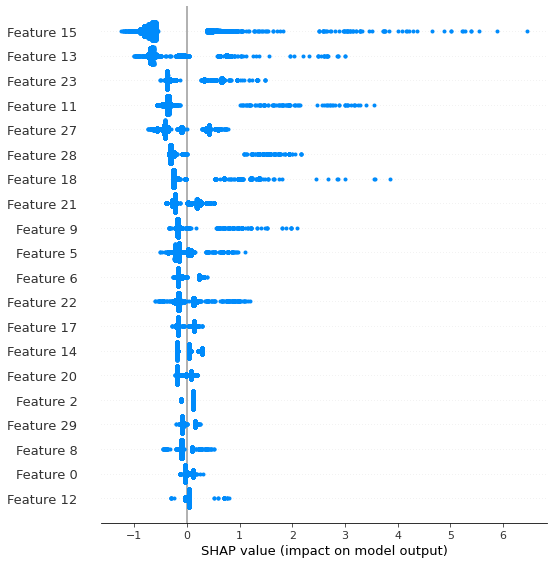

In [4]:
shap.summary_plot(shap_values)

The shap summary plot shows the importances of each individual feature on our segmented gradient boosted model. For example, Feature #15 seems to have a large effect on classifying observations with that feature as class zero.

# 5.3

In [343]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(shap_values)

In [344]:
clustered_labels = pd.Series(kmeans.labels_)

In [345]:
clf = DecisionTreeClassifier(max_depth = 5, random_state=0, max_leaf_nodes = 20)
clf.fit(X_train,clustered_labels)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=20, random_state=0)

In [354]:
shap_vals_df = pd.DataFrame(shap_values)

overall_var = (shap_vals_df.stack().std())**2
overall_var

0.05740513373533318

[Text(591.8181818181819, 996.6, 'node #0\nX[21] <= -0.089\ngini = 0.882\nsamples = 16020\nvalue = [339, 3351, 1601, 3082, 998, 27, 328, 767, 252, 122\n415, 72, 354, 1465, 1318, 41, 834, 353, 225, 76]'),
 Text(346.6363636363637, 815.4000000000001, 'node #1\nX[27] <= 0.193\ngini = 0.757\nsamples = 7349\nvalue = [339, 4, 2, 3082, 998, 4, 121, 270, 111, 46, 3\n24, 150, 1465, 0, 7, 499, 105, 93, 26]'),
 Text(219.81818181818184, 634.2, 'node #7\nX[23] <= 0.562\ngini = 0.607\nsamples = 5252\nvalue = [0, 4, 0, 3082, 998, 2, 0, 270, 62, 2, 0, 21\n114, 0, 0, 4, 499, 105, 71, 18]'),
 Text(135.27272727272728, 453.0, 'node #9\nX[13] <= -0.93\ngini = 0.411\nsamples = 4086\nvalue = [0, 4, 0, 3082, 0, 2, 0, 270, 43, 1, 0, 16, 95\n0, 0, 3, 499, 0, 60, 11]'),
 Text(67.63636363636364, 271.79999999999995, 'node #11\nX[13] <= -2.512\ngini = 0.372\nsamples = 642\nvalue = [0, 0, 0, 0, 0, 2, 0, 20, 5, 0, 0, 1, 95, 0\n0, 0, 499, 0, 20, 0]'),
 Text(33.81818181818182, 90.59999999999991, 'node #31\ngini = 0.175\n

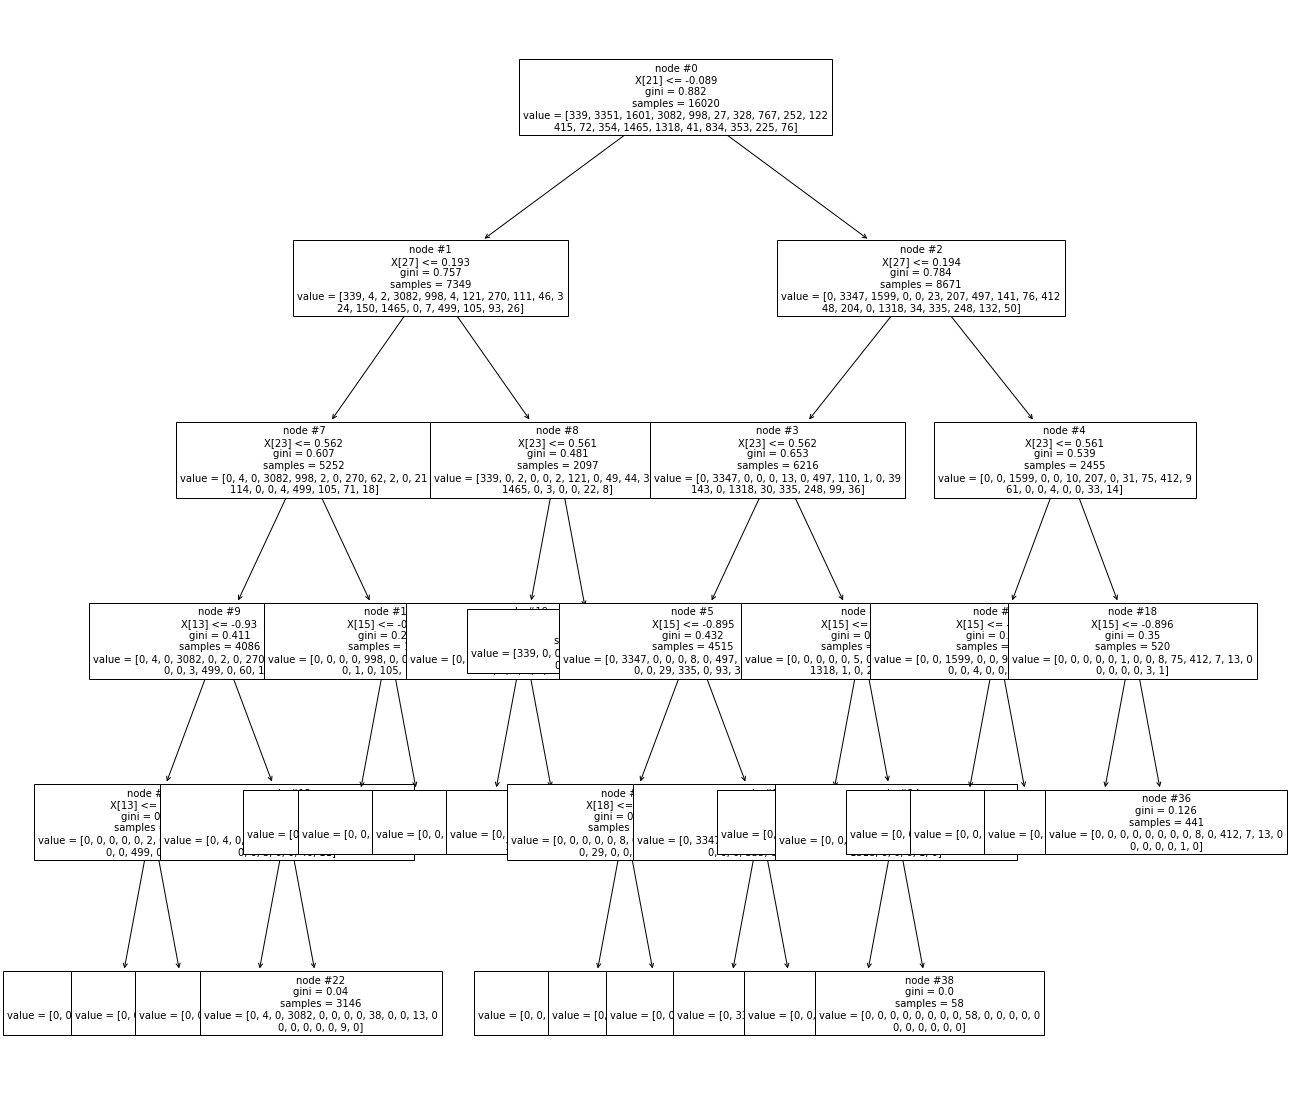

In [347]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20,20))

tree.plot_tree(clf,fontsize=10, node_ids=True)  

In [348]:
def RevTraverseTree(tree, node, rules):
    '''
    Traverase an skl decision tree from a node (presumably a leaf node)
    up to the top, building the decision rules. The rules should be
    input as an empty list, which will be modified in place. The result
    is a nested list of tuples: (feature, direction (left=-1), threshold).  
    The "tree" is a nested list of simplified tree attributes:
    [split feature, split threshold, left node, right node]
    '''
    # now find the node as either a left or right child of something
    # first try to find it as a left node
    try:
        prevnode = tree[2].index(node)
        leftright = -1
    except ValueError:
        # failed, so find it as a right node - if this also causes an exception, something's really f'd up
        prevnode = tree[3].index(node)
        leftright = 1
    # now let's get the rule that caused prevnode to -> node
    rules.append((tree[0][prevnode],leftright,tree[1][prevnode]))
    # if we've not yet reached the top, go up the tree one more step
    if prevnode != 0:
        RevTraverseTree(tree, prevnode, rules)

In [349]:
n = len(X_train)

# get the nodes which are leaves
leaves = clf.tree_.children_left == -1
leaves = np.arange(0,clf.tree_.node_count)[leaves]

# loop through each leaf and figure out the data in it
leaf_observations = np.zeros((n,len(leaves)),dtype=bool)
# build a simpler tree as a nested list: [split feature, split threshold, left node, right node]
thistree = [clf.tree_.feature.tolist()]
thistree.append(clf.tree_.threshold.tolist())
thistree.append(clf.tree_.children_left.tolist())
thistree.append(clf.tree_.children_right.tolist())
# get the decision rules for each leaf node & apply them
for (ind,nod) in enumerate(leaves):
    # get the decision rules in numeric list form
    rules = []
    RevTraverseTree(thistree, nod, rules)
    # convert & apply to the data by sequentially &ing the rules
    thisnode = np.ones(n,dtype=bool)
    for rule in rules:
        if rule[1] == 1:
            thisnode = np.logical_and(thisnode,shap_values[:,rule[0]] > rule[2])
        else:
            thisnode = np.logical_and(thisnode,shap_values[:,rule[0]] <= rule[2])
    # get the observations that obey all the rules - they are the ones in this leaf node
    leaf_observations[:,ind] = thisnode

In [350]:
leaf_df = pd.DataFrame(leaf_observations, columns = leaves)
leaf_df

,15,16,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16015,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
16016,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
16017,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
16018,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [351]:
# set up a new column
leaf_df['leaf node ID'] = leaf_df.iloc[:,1]

# for loop
for row in range(16020):
    for column in list(leaves):
        if leaf_df.loc[row, column] == True:
            leaf_df.loc[row, 'leaf node ID'] = column

leaf_df

,15,16,20,21,22,23,25,26,27,28,...,30,31,32,33,34,35,36,37,38,leaf node ID
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,28
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,37
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,22
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,16
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16015,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,22
16016,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,30
16017,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,16
16018,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,22


In [352]:
shap_vals_leaf = pd.concat([shap_vals_df,leaf_df[['leaf node ID']]],axis=1)

shap_vals_leaf

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,leaf node ID
0,0.109743,0.0,0.119277,0.0,0.015268,-0.227118,0.314286,0.000645,-0.108452,-0.204735,...,-0.200802,-0.403449,0.001331,-0.019044,-0.000164,0.594357,-0.340373,-0.099331,0.031831,28
1,-0.032982,0.0,0.119277,0.0,0.012930,-0.230697,-0.166676,-0.000145,-0.103599,-0.166903,...,0.135903,0.658548,0.000767,0.021004,-0.000081,-0.111786,-0.221052,0.147991,-0.031486,37
2,-0.034849,0.0,0.119277,0.0,0.012930,-0.156274,-0.166676,0.000645,-0.103371,-0.168461,...,-0.167085,-0.383638,0.000767,0.021004,-0.000081,-0.118997,-0.318990,-0.099331,0.031857,22
3,-0.034849,0.0,0.119277,0.0,0.012930,-0.231005,-0.089587,-0.000145,-0.100189,-0.167928,...,-0.148575,-0.383640,-0.000773,0.021004,0.000194,-0.419267,-0.307577,-0.099331,0.032040,16
4,-0.034849,0.0,0.119277,0.0,0.012930,0.025445,-0.087333,0.000645,-0.108452,-0.168596,...,-0.159694,-0.383639,-0.000773,-0.019044,-0.000164,-0.372861,-0.307577,-0.099331,-0.029416,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16015,-0.034849,0.0,0.119277,0.0,0.012930,0.025445,-0.166676,0.000645,-0.103957,-0.167928,...,-0.148622,-0.383639,0.000767,-0.019044,-0.000081,-0.419267,-0.307577,-0.099331,-0.029207,22
16016,-0.032982,0.0,0.119277,0.0,0.012930,-0.156772,-0.166676,0.000645,0.090052,-0.166903,...,0.122594,0.658550,0.000767,-0.019044,-0.000081,-0.434076,-0.262087,-0.099331,-0.031486,30
16017,-0.034403,0.0,0.119277,0.0,0.012930,0.069784,-0.166676,-0.000145,-0.099623,-0.167928,...,-0.158126,-0.330721,0.000767,-0.019044,-0.000081,-0.113646,-0.307467,-0.099331,0.032040,16
16018,-0.034814,0.0,0.119277,0.0,0.012930,0.025445,-0.166676,0.000645,-0.100279,-0.167928,...,0.123415,-0.330721,0.000767,-0.019044,-0.000081,-0.434076,-0.318990,-0.099331,-0.031486,22


In [353]:
grps = shap_vals_leaf.groupby('leaf node ID')

for key, group in grps:
    print('Leaf node ID:', key)
    print('Variance:', (group.T[:-1].stack().std())**2)

Leaf node ID: 15
Variance: 0.42580788948797216
Leaf node ID: 16
Variance: 0.21985188279556114
Leaf node ID: 20
Variance: 0.2852932415170012
Leaf node ID: 21
Variance: 0.3694677399608999
Leaf node ID: 22
Variance: 0.2232475698063281
Leaf node ID: 23
Variance: 0.4014231682642833
Leaf node ID: 25
Variance: 0.3599242978357407
Leaf node ID: 26
Variance: 0.2428757370722954
Leaf node ID: 27
Variance: 0.378491944749949
Leaf node ID: 28
Variance: 0.2514857270217518
Leaf node ID: 29
Variance: 0.5510399776352235
Leaf node ID: 30
Variance: 0.26153387091047287
Leaf node ID: 32
Variance: 0.4478537758796845
Leaf node ID: 33
Variance: 0.3850954232818102
Leaf node ID: 35
Variance: 0.3145407926465811
Leaf node ID: 36
Variance: 0.2973498998298251
Leaf node ID: 37
Variance: 0.25710551042593416
Leaf node ID: 38
Variance: 0.4059627156178296
